# 1. Data Generator
- Raw Data를 읽어옴
- 여기서 만들어진 데이터는 모델의 입력으로 들어감

In [1]:
import os
import numpy as np
# import librosa
from tensorflow.keras.utils import Sequence

import scipy.signal
from scipy.io import wavfile

In [2]:
class RawForVAEGenerator(Sequence):
    def __init__(self, source, wav_dir, files, sourNum='s1', batch_size=10, shuffle=True):
        self.source = source
        self.wav_dir = wav_dir
        self.files = files
        self.sourNum = sourNum
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
        self.sample_rate = 8000
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.source))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __audioread__(self, path, offset=0.0, duration=None, sample_rate=16000):
#         signal = librosa.load(path, sr=self.sample_rate, mono=False, offset=offset, duration=duration)
        
#         return signal[0]
    
        signal_rate, signal = wavfile.read(path)
        number_of_samples = round(len(signal) * float(self.sample_rate) / signal_rate)
        signal = scipy.signal.resample(signal, number_of_samples)
        signal /= np.max(np.abs(signal),axis=0)

        return signal
    
    def __padding__(self, data):
        n_batch = len(data)
        max_len = max([d.shape[0] for d in data])
        extrapadding = int(np.ceil(max_len / self.sample_rate) * self.sample_rate)
        pad = np.zeros((n_batch, extrapadding))
        
        for i in range(n_batch):
            pad[i, :data[i].shape[0]] = data[i]
        
        return np.expand_dims(pad, -1)
        
    def __data_generation__(self, source_list):
        wav_list = []
        for name in source_list:
            name = name.strip('\n')
            
            s_wav_name = self.wav_dir + self.files + '/' + self.sourNum + '/' + name
            
            # ------- AUDIO READ -------
            s_wav = (self.__audioread__(s_wav_name,  offset=0.0, duration=None, sample_rate=self.sample_rate))
            # --------------------------
            
            # ------- PADDING -------
#             pad_len = max(len(samples1),len(samples2))
#             pad_s1 = np.concatenate([s1_wav, np.zeros([pad_len - len(s1_wav)])])
            
#             extrapadding = ceil(len(pad_s1) / sample_rate) * sample_rate - len(pad_s1)
#             pad_s1 = np.concatenate([pad_s1, np.zeros([extrapadding - len(pad_s1)])])
#             pad_s2 = np.concatenate([s2_wav, np.zeros([extrapadding - len(s2_wav)])])
            # -----------------------
            
            wav_list.append(s_wav)
        
        return wav_list, wav_list, source_list
            
    
    def __len__(self):
        return int(np.floor(len(self.source) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        source_list = [self.source[k] for k in indexes]
        
        if self.files is not 'tt':
            sour, labels, _ = self.__data_generation__(source_list)
            
            # Get Lengths(K value of each batch)
            lengths = np.array([m.shape[0] for m in sour])
            exp = np.expand_dims(lengths, 1)
            exp = np.expand_dims(exp, -1) # [Batch, 1, 1] (length)
            
            # Padding
            sour_pad = self.__padding__(sour) # [Batch, Time_step, Dimension(=1)]
            label_pad = self.__padding__(labels) # [Batch, Time_step, Dimension(=1)]
            
#             return sour_pad, np.concatenate([label_pad, exp], axis=1)
            return sour_pad, label_pad
        else:
            sour, labels, name = self.__data_generation__(source_list)
            
            # Get Lengths(K value of each batch)
            lengths = np.array([m.shape[0] for m in sour])
            exp = np.expand_dims(lengths, 1)
            exp = np.expand_dims(exp, -1) # [Batch, 1, 1] (length)
            
            # Padding
            sour_pad = self.__padding__(sour) # [Batch, Time_step, Dimension(=1)]
            
            return sour_pad, exp, name

<>:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\lynn1\AppData\Local\Temp/ipykernel_7820/994479228.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.files is not 'tt':


In [3]:
class RawStackForVAEGenerator(Sequence):   ## sequence 상속
    def __init__(self, source, wav_dir, files, sourNum='s1', batch_size=16, shuffle=True):
        self.source = source
        self.wav_dir = wav_dir
        self.files = files
        self.sourNum = sourNum
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
        self.sample_rate = 8000
    
    def on_epoch_end(self):   ## 하나의 epoch이 끝나면 자동으로 실행
        self.indexes = np.arange(len(self.source))
        
        if self.shuffle:  ## 다른 샘플 shuffling
            np.random.shuffle(self.indexes)
    
    def __audioread__(self, path, offset=0.0, duration=None, sample_rate=16000):   ## 다른 폴더에 있는 오디어 파일 데이터를 읽어옴
#         signal = librosa.load(path, sr=sample_rate, mono=False, offset=offset, duration=duration)

#         return signal[0]
    
        signal_rate, signal = wavfile.read(path)
        number_of_samples = round(len(signal) * float(self.sample_rate) / signal_rate)
        signal = scipy.signal.resample(signal, number_of_samples)
        signal /= np.max(np.abs(signal),axis=0)
        
        return signal
    
    def __padding__(self, data):   ## 짧은 오디오 데이터에 0을 붙여서 길이를 맞춰줌
        n_batch = len(data)
        max_len = max([d.shape[0] for d in data])
        pad = np.zeros((n_batch, max_len, data[0].shape[1]))
        
        for i in range(n_batch):
            pad[i, :data[i].shape[0]] = data[i]
        
        return pad
        
    def __data_generation__(self, source_list):   ## audio-read해서 읽어온 데이터를 전처리
        L = 40
        
        wav_list = []
        label_wav_list = []
        for name in source_list:
            name = name.strip('\n')
            
            s_wav_name = self.wav_dir + self.files + '/' + self.sourNum + '/' + name
            
            # ------- AUDIO READ -------
            s_wav = (self.__audioread__(s_wav_name,  offset=0.0, duration=None, sample_rate=self.sample_rate))
#             print(s_wav.shape)
            # --------------------------
            
            # ------- TIME AXIS CALCULATE -------
            K = int(np.ceil(len(s_wav) / L))
            
            if K//4 != 0:          # stride=2일 때, K를 4의 배수로 만들어줌
                K = ((K//4)+1)*4
            # -----------------------------------
            
            # ------- PADDING -------
            pad_len = K * L
            pad_s = np.concatenate([s_wav, np.zeros([pad_len - len(s_wav)])])
            # -----------------------
            
            # ------- RESHAPE -------
            s = np.reshape(pad_s, [K, L])
            # -----------------------
            
            wav_list.append(s)
            label_wav_list.append(np.expand_dims(s_wav, 1))
        
        return wav_list, label_wav_list, source_list
            
    
    def __len__(self):
        return int(np.floor(len(self.source) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        source_list = [self.source[k] for k in indexes]
        
        if self.files is not 'tt':
            sour, labels, _ = self.__data_generation__(source_list)   ## 데이터 받아오기
            
            # Get Lengths(label length)
            lengths = np.array([m.shape[0] for m in labels])
            tiled = np.tile(np.expand_dims(lengths, 1), [1, labels[0].shape[1]])
            tiled = np.expand_dims(tiled, 1)
            
            # Padding
            sour_pad = self.__padding__(sour) # [Batch, Time_step_for_stack, Dimension(=40)]
            label_pad = self.__padding__(labels) # [Batch, Time_step, Dimension(=1)]
            
            return sour_pad, sour_pad
        else:
            sour, labels, name = self.__data_generation__(source_list)
            
            # Get Lengths(K value of each batch)
#             lengths = np.array([m.shape[0] for m in mix])
#             tiled = np.tile(np.expand_dims(l bvengths, 1), [1, labels[0].shape[1]])
#             tiled = np.expand_dims(tiled, 1)
            
            # Padding
            sour_pad = self.__padding__(sour) # [Batch, Time_step, Dimension]
            
            return sour_pad, tiled, name

<>:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\lynn1\AppData\Local\Temp/ipykernel_7820/894115812.py:84: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if self.files is not 'tt':


## Data를 어떻게 읽는지에 대한 부분

In [4]:
WAV_DIR = './mycode/wsj0_2mix/use_this/'
LIST_DIR = './mycode/wsj0_2mix/use_this/lists/'

In [5]:
# Directory List file create

wav_dir = WAV_DIR
output_lst = LIST_DIR

for folder in ['tr', 'cv', 'tt']:
    wav_files = os.listdir(wav_dir + folder + '/mix')
    output_lst_files = output_lst + folder + '_wav.lst'
    with open(output_lst_files, 'w') as f:
        for file in wav_files:
            f.write(file + "\n")

print("Generate wav file to .lst done!")

Generate wav file to .lst done!


In [6]:
batch_size_for_generator = 10

train_dataset = 0
valid_dataset = 0
test_dataset = 0

name_list = []
for files in ['tr', 'cv', 'tt']:
    # --- Lead lst file ---
    output_lst_files = LIST_DIR + files + '_wav.lst'
    fid = open(output_lst_files, 'r')
    lines = fid.readlines()
    fid.close()
    # ---------------------
    
    if files == 'tr':
        train_dataset = RawStackForVAEGenerator(lines, WAV_DIR, files, 's1', batch_size_for_generator)
    elif files == 'cv':
        valid_dataset = RawStackForVAEGenerator(lines, WAV_DIR, files, 's1', batch_size_for_generator)
    else:
        test_batch = 1
        test_dataset = RawStackForVAEGenerator(lines, WAV_DIR, files, 's1', test_batch)

In [7]:
a, b = next(iter(train_dataset))
print(a.shape)
print(b.shape)

(10, 1568, 40)
(10, 1568, 40)


# 2. Building VQ-VAE model with Gumbel Softmax

In [8]:
import threading
from scipy.io.wavfile import write as wav_write
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras import backend as Kb
import numpy as np
import pandas as pd
from importlib import reload
import time
from tensorflow.keras.models import Model, Sequential, load_model

In [9]:
def mkdir_p(path):
    """ Creates a path recursively without throwing an error if it already exists
    :param path: path to create
    :return: None
    """
    if not os.path.exists(path):
        os.makedirs(path)

In [10]:
mkdir_p('./CKPT/') # model check point 폴더 만드는 코드
filepath = "./CKPT/CKP_ep_{epoch:d}__loss_{val_loss:.5f}_.h5"

In [11]:
initial_learning_rate = 0.001

# learning rate를 점점 줄이는 부분
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

# validation loss에 대해서 좋은 것만 저장됨
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min'
)

# early stop 하는 부분인데, validation loss에 대해서 제일 좋은 모델이 저장됨
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True
)

In [12]:
class VectorQuantizer(layers.Layer):  
    def __init__(self, num_embeddings, embedding_dim, name='embedding_vqvae', beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = (beta)

        # Initialize the embeddings which we will quantize
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name=name,
        )

    def call(self, x):
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])
        
        # Quantization
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2
        )
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        quantization_loss = commitment_loss + codebook_loss
        
        self.add_loss(0.5 * quantization_loss)

        # Straight-through estimator
        quantized = x + tf.stop_gradient(quantized - x)
        
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances
        encoding_indices = tf.argmin(distances, axis=1)
        
        return encoding_indices

In [13]:
class GumbelSoftmax(layers.Layer):
    def __init__(self, temperature=0.5, hard=False, name = 'gumbel_softmax',**kwargs):
        super(GumbelSoftmax, self).__init__(name=name, **kwargs)
        
        self.temperature = temperature
        self.hard = hard
    
    def sample_gumbel(self, shape, eps=1e-20): 
        """Sample from Gumbel(0, 1)"""
        U = tf.random.uniform(shape,minval=0,maxval=1)
        
        return -tf.math.log(-tf.math.log(U + eps) + eps)

    def gumbel_softmax_sample(self, logits, temperature): 
        """ Draw a sample from the Gumbel-Softmax distribution"""
        y = logits + self.sample_gumbel(tf.shape(logits))
        
        return tf.nn.softmax(y / temperature)

    def call(self, inputs):
        y = self.gumbel_softmax_sample(inputs, self.temperature)
        
        if self.hard:
            y_hard = tf.cast(tf.equal(y, tf.math.reduce_max(y, 2, keepdims=True)), y.dtype)
            y = tf.stop_gradient(y_hard - y) + y
        
        return y

    
class Encoder(layers.Layer):  
    def __init__(self, kernel, latent_dim, strides, name = 'encoder',**kwargs):  ## ak==latendt dim : 40 -> latent dim
        super(Encoder, self).__init__(name=name, **kwargs)
        
        self.conv1d_1 = layers.Conv1D(filters=2*latent_dim, kernel_size=kernel, strides=strides, activation='tanh', padding='same')
        self.conv1d_2 = layers.Conv1D(filters=latent_dim, kernel_size=kernel, strides=strides, activation='tanh', padding='same')
        self.dropout_1 = layers.Dropout(0.2)
        self.resblock_1 = ResBlock(filters=latent_dim)
#         self.maxpooling1d_1 = layers.MaxPooling1D()
#         self.upsampling1d_1 = layers.UpSampling1D()
#         self.batchnorm1d_1 = layers.BatchNormalization()
        
    def call(self, inputs):
        logit1 = self.conv1d_2(inputs)
        print('conv1d ', logit1.shape)
#         logit2 = self.conv1d_2(logit1)
#         print('Encoder_conv1d ', logit2.shape)
#         logit2 = self.resblock_1(logit1)  
        
#         logit2 = self.dropout_1(logit1)
#         print('Encoder_dropout1d ', logit2.shape)
#         logit3 = self.conv1d_2(logit2)
#         print('Encoder_conv1d ', logit3.shape)  
        
        return logit1


class Decoder(layers.Layer):  
    def __init__(self, kernel, latent_dim, strides, activation, name = 'decoder',**kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        
        self.trans_conv1d_1 = layers.Conv1DTranspose(filters=2*latent_dim, kernel_size=kernel, strides=strides, activation=activation, padding='same')
        self.trans_conv1d_2 = layers.Conv1DTranspose(filters=latent_dim, kernel_size=kernel, strides=strides, activation=activation, padding='same')
        self.resblock_1 = ResBlock(filters=latent_dim)
#         self.upsampling_1 = layers.UpSampling1D()
        
    def call(self, inputs):
        logit1 = self.trans_conv1d_2(inputs)
        print('transconv1d ', logit1.shape)
#         logit2 = self.resblock_1(logit1)
#         logit3 = self.trans_conv1d_2(logit)
#         print('Decoder_transconv1d ', x.shape)
        
        return logit1
    
    
class ResBlock(layers.Layer):  
    def __init__(self, filters, name = 'resblock', **kwargs):
        super(ResBlock, self).__init__(name=name, **kwargs)
        
        self.conv1d_1 = layers.Conv1D(filters=filters, kernel_size=1, strides=1, activation='tanh')
        
    def call(self, inputs):
        logit1 = self.conv1d_1(inputs)
        logit2 = inputs + logit1
        
        return logit2

In [14]:
# Custom Metric Si-sdr

class SiSdr(keras.metrics.Metric):
    def __init__(self, name="Si-sdr", **kwargs):
        super(SiSdr, self).__init__(name=name, **kwargs)
        self.sdr = self.add_weight(name="sdr", initializer="zeros")
        self.count = self.add_weight(name="cnt", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        ori_length = tf.shape(y_true)[1]
        y_true_flatten = self.overlab_add(y_true)
        y_pred_flatten = self.overlab_add(y_pred)
        
        # Label & Length divide
        labels = tf.slice(y_true, [0, 0, 0], [-1, ori_length-1, -1]) # [batch_size, length_size, 1]
        lengths = tf.slice(y_true, [0, ori_length-1, 0], [-1, -1, 1]) # [batch_size, 1, 1]
        
        labels = y_true_flatten
        
        # Check sequence length
        batch_size = tf.shape(labels)[0]
        label_size = tf.shape(labels)[1]
        pred_size = tf.shape(y_pred_flatten)[1]
        feature_size = tf.shape(labels)[-1]
        
        # Change sequence length
        if label_size < pred_size:
            y_pred_flatten = tf.slice(y_pred_flatten, [0, 0, 0], [-1, label_size, -1])
        elif label_size > pred_size:
            labels = tf.slice(labels, [0, 0, 0], [-1, pred_size, -1])

        # SI-SDR
        target = tf.linalg.matmul(y_pred_flatten, labels, transpose_a=True) * labels / tf.expand_dims(tf.experimental.numpy.square(tf.norm(labels, axis=1)), axis=-1)
        noise = y_pred_flatten - target
        values = 10 * tf.experimental.numpy.log10(tf.experimental.numpy.square(tf.norm(target, axis=1)) / tf.experimental.numpy.square(tf.norm(noise, axis=1)))
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.sdr.assign_add(tf.reduce_sum(values))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))
    
    def overlab_add(self, y_pred):
        batch_size = tf.shape(y_pred)[0]

        return tf.reshape(y_pred, [batch_size, -1, 1])

    def result(self):
        return self.sdr / self.count

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.sdr.assign(0.0)
        self.count.assign(0.0)

In [15]:
# Custom loss

# Custom mse
def custom_mse(y_true, y_pred):
    loss = tf.reduce_sum(tf.pow(y_pred - y_true, 2), axis=[1, 2])
    loss = tf.reduce_mean(loss)

    return loss


# Custom si-sdr loss
def custom_sisdr_loss(y_true, y_pred):
    ori_length = tf.shape(y_true)[1]

    # Label & Length divide
    labels = tf.slice(y_true, [0, 0, 0], [-1, ori_length-1, -1]) # [batch_size, length_size, 1]
    lengths = tf.slice(y_true, [0, ori_length-1, 0], [-1, -1, 1]) # [batch_size, 1, 1]

    target = tf.linalg.matmul(y_pred, labels, transpose_a=True) * labels / tf.expand_dims(tf.experimental.numpy.square(tf.norm(labels, axis=1)), axis=-1)
    noise = y_pred - target
    si_sdr = 10 * tf.experimental.numpy.log10(tf.experimental.numpy.square(tf.norm(target, axis=1)) / tf.experimental.numpy.square(tf.norm(noise, axis=1)))
    si_sdr = tf.reduce_mean(si_sdr) * -1

    return si_sdr

In [16]:
# Here vnsmsrj

def overlab_add(y_pred):
    batch_size = tf.shape(y_pred)[0]
    
    return tf.reshape(y_pred, [batch_size, -1, 1])

In [17]:
class Vq_vae(keras.Model):   ####
    def __init__(self, embedding_dim, num_embeddings, gumbel_hard=False, for_predict=False, name='vqvae', **kwargs):
        super(Vq_vae, self).__init__(name=name, **kwargs)
        
        self.for_predict = for_predict
        
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        
        self.encoder1 = Encoder(4, 128, 2, name='encoder1')
        self.encoder2 = Encoder(4, embedding_dim, 2, name='encoder2')
#         self.encoder2_2 = Encoder(4, embedding_dim, 1, name='encoder2_2')
        self.quantize1 = VectorQuantizer(num_embeddings, embedding_dim, name='embedding_vqvae1')  
        
        self.decoder1 = Decoder(4, 128, 2, 'relu', name='decoder1')  
#         self.encoder3 = Encoder(1, embedding_dim, 1, name='encoder3')
#         self.quantize2 = VectorQuantizer(num_embeddings, embedding_dim, name='embedding_vqvae2')
        
#         self.decoder2 = Decoder(4, 128, 1, 'tanh', name='decoder2')
        self.decoder3 = Decoder(4, 40, 2, None, name='decoder3')
        
    def call(self, inputs, load=False):
        if load:
            inputs = layers.Input(shape=(None, 40))
               
        if self.for_predict:
            encode1 = self.encoder1(inputs)
            encode2 = self.encoder2(encode1)
            one_hot_enc = tf.cast(tf.equal(encode2, tf.math.reduce_max(encode2, 2, keepdims=True)), encode2.dtype)
            sample = self.sampled(one_hot_enc)
            decode = self.decoder(sample)
            
        else:  
#             print('# Encoder1')
#             encode1 = self.encoder1(inputs)
#             print('\n# Encoder2')
#             encode2 = self.encoder2(encode1)
# #             print('# Encoder2-2')  
# #             encode2_2 = self.encoder2_2(encode2)   # top level 추가
#             print('\n# Quantization1')
#             quantization1 = self.quantize1(encode2)  
#             print('encoder2 ', quantization1.shape)
#             print('\n# Decoder1')
#             decode1 = self.decoder1(quantization1)  
# #             print('# Decoder1_2')
# #             decode1_2 = self.decoder1(decode1)   # new bottom level
            
#             print('\n# Enc')
# #             enc = layers.Concatenate()([encode1, decode1])
#             enc = tf.math.multiply(encode1, decode1)
#             print('encoder1+decoder1 ', enc.shape)
#             print('\n# Encoder3')
#             encode3 = self.encoder3(enc)
#             print('\n# Quantization2')
#             quantization2 = self.quantize2(encode3)
#             print('encoder3 ', quantization2.shape)
#             print('\n# Decoder2')
#             decode2 = self.decoder2(quantization2)
            
#             print('\n# Quant')
#             quant = layers.Concatenate()([decode2, quantization2])
#             print('decoder2+quantization2 ', quant.shape)
#             print('\n# Decoder3')
#             decode3 = self.decoder3(quant)
            
            print(inputs.shape)
            print('# Encoder1')
            encode1 = self.encoder1(inputs)
            print('\n# Encoder2')
            encode2 = self.encoder2(encode1)
            print('\n# Quantization1')
            quantization1 = self.quantize1(encode2)  
            print('encoder2 ', quantization1.shape)            
            print('\n# Decoder1')
            decode1 = self.decoder1(quantization1)
#             print('\n# Quantization2')  #
#             quantization2 = self.quzntize2(decode1)  #
            print('\n# Enc')
            enc = layers.Concatenate()([encode1, decode1])
#             enc = tf.math.multiply(encode1, decode1)
            print('encoder1+decoder1 ', enc.shape)
            print('\n# Decoder2')
            decode3 = self.decoder3(enc)
            
        return decode3

In [18]:
def gen_train_data_generator():
    for i in range(train_dataset.__len__()):
        data = np.squeeze(train_dataset.__getitem__(i)[0], axis=0)
        label = np.squeeze(train_dataset.__getitem__(i)[1], axis=0)
        
        yield (data, label)

def gen_valid_data_generator():
    for i in range(valid_dataset.__len__()):
        data = np.squeeze(valid_dataset.__getitem__(i)[0], axis=0)
        label = np.squeeze(valid_dataset.__getitem__(i)[1], axis=0)
        
        yield (data, label)

# 여기는 기존의 .fit() 함수를 사용해서 학습하는 부분임

In [23]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

tf.random.set_seed(42)

embedding_dim = 64
num_embeddings = 512
epoch = 20

strategy = tf.distribute.MirroredStrategy(['/cpu:0'])
print('장치의 수: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    model_path = './CKPT/CKP_ep_594__loss_229.89435_.h5'
    
    loss_fun = custom_mse
#     loss_fun = custom_sisdr_loss
    
    vq_vae = Vq_vae(embedding_dim, num_embeddings, gumbel_hard=False)

    optimizer = keras.optimizers.Nadam(learning_rate=0.001)
    vq_vae.compile(optimizer, loss=loss_fun, metrics=[SiSdr()])
    
#     vq_vae(0, True)
#     vq_vae.summary()
    
    # 사용 안할 때는 load_model 주석 처리 하자
#     vq_vae.load_weights(model_path)
    # ----------------------------------------
    
    tf.executing_eagerly()
    
    
history = vq_vae.fit(
    train_dataset,
    epochs=epoch,
    validation_data=valid_dataset,
    shuffle=True,
    callbacks=[checkpoint_cb],
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
장치의 수: 1
(10, 1848, 40)
# Encoder1
conv1d  (10, 924, 128)

# Encoder2
conv1d  (10, 462, 64)

# Quantization1
encoder2  (10, 462, 64)

# Decoder1
transconv1d  (10, 924, 128)

# Enc
encoder1+decoder1  (10, 924, 256)

# Decoder2
transconv1d  (10, 1848, 40)
Epoch 1/20
(None, None, None)
# Encoder1
conv1d  (None, None, 128)

# Encoder2
conv1d  (None, None, 64)

# Quantization1
encoder2  (None, None, 64)

# Decoder1
transconv1d  (None, None, 128)

# Enc
encoder1+decoder1  (None, None, 256)

# Decoder2
transconv1d  (None, None, 40)
(None, None, None)
# Encoder1
conv1d  (None, None, 128)

# Encoder2
conv1d  (None, None, 64)

# Quantization1
encoder2  (None, None, 64)

# Decoder1
transconv1d  (None, None, 128)

# Enc
encoder1+decoder1  (None, None, 256)

# Decoder2
transconv1d  (None, None, 40)
192/192 [==============================] - ETA: 0s - loss: 101.6929 - Si-sdr: 8.44 - ETA: 0s - loss: 

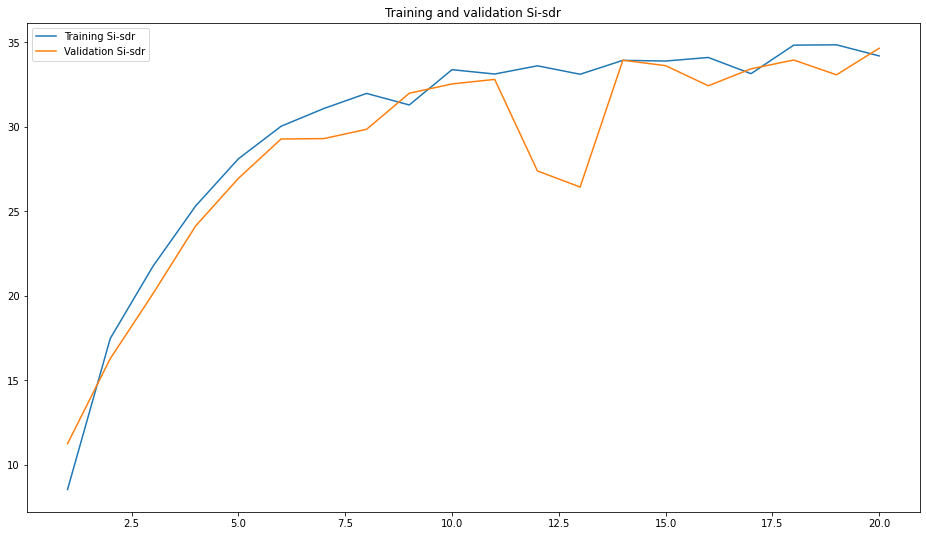

In [24]:
sisdr = history.history['Si-sdr'] # Training loss.
val_sisdr = history.history['val_Si-sdr'] # Validation loss.
num_epochs = range(1, 1 + len(history.history['Si-sdr'])) # Number of training epochs.

plt.figure(figsize=(16,9))
plt.plot(num_epochs, sisdr, label='Training Si-sdr') # Plot training loss.
plt.plot(num_epochs, val_sisdr, label='Validation Si-sdr') # Plot validation loss.

plt.title('Training and validation Si-sdr')
plt.legend(loc='best')
plt.show()

In [341]:
sisdr32 = history.history['Si-sdr']
val_sisdr32= history.history['val_Si-sdr']

## 2.2. Encoder 부르는 방법, Decoder에 값 넣는 방법

In [ ]:
latent_size = 512
epoch = 200
BATCH_SIZE = 2

strategy = tf.distribute.MirroredStrategy(['cpu:0'])
print('장치의 수: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    model_path = './CKPT/CKP_ep_283__loss_141.77045_.h5'
    
    vq_vae = Vq_vae(latent_size, num_embeddings, gumbel_hard=False)
    vq_vae(0, True)
    vq_vae.summary()
    
    vq_vae.load_weights(model_path)
    
    # 이렇게 하면, transforer의 input으로 들어가는 one-hot 형식의 값을 얻을 수 있음
    for inputs, label in train_dataset:
        encode = vq_vae.encoder(inputs).numpy()
        encode_onehot = tf.cast(tf.equal(encode, tf.math.reduce_max(encode, 2, keepdims=True)), encode.dtype)
    
    # 이렇게 하면, transformer의 output을 vq-vae의 decoder 입력으로 넣을 수 있음
    for inputs, label in train_dataset:
        encode = vq_vae.encoder(inputs).numpy()
        encode_onehot = tf.cast(tf.equal(encode, tf.math.reduce_max(encode, 2, keepdims=True)), encode.dtype)
        
        # 이렇게 이전 layer의 출렫을 넣으면 됨
        decode = vq_vae.decoder(encode_onehot).numpy()

# 3. Test Model

In [ ]:
def mkdir_p(path):
    """ Creates a path recursively without throwing an error if it already exists
    :param path: path to create .//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
    :return: None
    """
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
mkdir_p('./test_wav/') # Result wav 폴더 만드는 코드

In [ ]:
def audiowrite(data, path, samplerate=16000, normalize=False, threaded=True):
    """ Write the audio data ``data`` to the wav file ``path``
    The file can be written in a threaded mode. In this case, the writing
    process will be started at a separate thread. Consequently, the file will
    not be written when this function exits.
    :param data: A numpy array with the audio data
    :param path: The wav file the data should be written to
    :param samplerate: Samplerate of the audio data
    :param normalize: Normalize the audio first so that the values are within
        the range of [INTMIN, INTMAX]. E.g. no clipping occurs
    :param threaded: If true, the write process will be started as a separate
        thread
    :return: The number of clipped samples
    """
    data = data.copy()
    int16_max = np.iinfo(np.int16).max
    int16_min = np.iinfo(np.int16).min

    if normalize:
        if not data.dtype.kind == 'f':
            data = data.astype(np.float)
        data /= np.max(np.abs(data))

    if data.dtype.kind == 'f':
        data *= int16_max

    sample_to_clip = np.sum(data > int16_max)
    if sample_to_clip > 0:
        print('Warning, clipping {} samples'.format(sample_to_clip))
    data = np.clip(data, int16_min, int16_max)
    data = data.astype(np.int16)

    if threaded:
        threading.Thread(target=wav_write, args=(path, samplerate, data)).start()
    else:
        wav_write(path, samplerate, data)

    return sample_to_clip

In [ ]:
with tf.device('/cpu:0'):
    latent_size = 1024
    sample_rate = 8000
    model_path = './CKPT/CKP_ep_293__loss_49.28763_.h5'
    
    vq_vae = Vq_vae(latent_size, num_embeddings, for_predict=True)
    vq_vae(0, True)
    vq_vae.summary()
    vq_vae.load_weights(model_path)

    for batch in test_dataset:
        input_batch, length_batch, name = batch

        result = vq_vae.predict(input_batch)
        
        wav_name = './test_wav/' + name[0][:-5] + '_s1.wav'
        audiowrite(result[0], wav_name, sample_rate, True, True)

AttributeError: ignored

# 여기 밑에는 연습장임

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding

model = Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(None, 1)))
model.add(layers.Conv1D(filters=20, kernel_size=3, padding='same'))

input_array = np.random.randn(2, 10, 1)
input_array2 = np.random.randn(2, 9, 1)
with tf.device('/cpu:0'):
    model.compile('rmsprop', 'mse')

    output_array = model.predict(input_array)
    output_array2 = model.predict(input_array2)

In [ ]:
tf.reduce_sum(output_array, axis=[1, 2])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 9.221684, 10.636035], dtype=float32)>

In [ ]:
tf.unstack(output_array, axis=1)

[<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
 array([[ 0.05127785,  0.04667316,  0.02635628, ...,  0.04573939,
          0.01375185, -0.01533533],
        [ 0.01121127,  0.06675138,  0.0021627 , ...,  0.07490488,
          0.07613068,  0.02180689]], dtype=float32)>,
 <tf.Tensor: shape=(2, 512), dtype=float32, numpy=
 array([[ 0.08263874,  0.03258345,  0.01568549, ...,  0.03589562,
         -0.01625197, -0.03177397],
        [ 0.13691738,  0.09397386, -0.01036285, ..., -0.00614451,
          0.05317175, -0.01284541]], dtype=float32)>,
 <tf.Tensor: shape=(2, 512), dtype=float32, numpy=
 array([[ 0.07028106,  0.00527185,  0.01043324, ...,  0.0617263 ,
         -0.03244079, -0.01786789],
        [ 0.10520705,  0.042405  ,  0.03726472, ...,  0.07816655,
          0.03663039, -0.03122897]], dtype=float32)>,
 <tf.Tensor: shape=(2, 512), dtype=float32, numpy=
 array([[ 0.07235897,  0.00636261, -0.03309729, ...,  0.05743181,
         -0.01674554, -0.01104611],
        [ 0.11989237,  0.047

In [ ]:
print(output_array)
print(output_array.shape)
print(output_array2.shape)

[[[ 0.05127785  0.04667316  0.02635628 ...  0.04573939  0.01375185
   -0.01533533]
  [ 0.08263874  0.03258345  0.01568549 ...  0.03589562 -0.01625197
   -0.03177397]
  [ 0.07028106  0.00527185  0.01043324 ...  0.0617263  -0.03244079
   -0.01786789]
  ...
  [-0.01148595  0.03309207 -0.02289026 ...  0.02078854 -0.06813245
   -0.09970599]
  [ 0.07415138  0.0991153  -0.03032039 ...  0.01240078 -0.04231954
   -0.04340101]
  [ 0.02075784  0.00618587 -0.07708566 ...  0.10809869  0.01363952
    0.02574195]]

 [[ 0.01121127  0.06675138  0.0021627  ...  0.07490488  0.07613068
    0.02180689]
  [ 0.13691738  0.09397386 -0.01036285 ... -0.00614451  0.05317175
   -0.01284541]
  [ 0.10520705  0.042405    0.03726472 ...  0.07816655  0.03663039
   -0.03122897]
  ...
  [ 0.04621019  0.06871783  0.00798892 ...  0.01603857  0.04825678
    0.01381727]
  [ 0.0583101   0.0205835  -0.01229584 ... -0.01952541  0.00030562
   -0.05487346]
  [-0.00304264 -0.00650905 -0.00512165 ...  0.01797911 -0.00719647
   -0.

In [ ]:
one_hot = tf.math.argmax(tf.cast(tf.equal(output_array, tf.math.reduce_max(output_array, 2, keepdims=True)), output_array.dtype), axis=-1)
print(one_hot.shape)
print(one_hot)
# layers.Embedding(512, 512)(one_hot)

(2, 10)
tf.Tensor(
[[259 259  34  50   0 110   0 305 200 287]
 [257   0 200 259  34 200 509 110 200 287]], shape=(2, 10), dtype=int64)


In [ ]:
one_hot = tf.math.argmax(output_array, axis=-1)
print(one_hot.shape)
print(one_hot)

(2, 10)
tf.Tensor(
[[228 249 283 206  20 206 435  32 270  30]
 [428 206  20 244 357 289 324 249 498 134]], shape=(2, 10), dtype=int64)


In [ ]:
qy = tf.nn.softmax(output_array)
log_qy = tf.math.log(qy + 1e-10)
log_uniform = qy * (log_qy - tf.math.log(1.0 / 512))
kl_loss = tf.reduce_sum(log_uniform, axis=[1, 2])
kl_loss = tf.reduce_mean(kl_loss)

print(kl_loss)

tf.Tensor(0.012074914, shape=(), dtype=float32)


In [ ]:
batch_size = tf.shape(output_array)[0]
array1_size = tf.shape(output_array)[1]
array2_size = tf.shape(output_array2)[1]
feature_size = tf.shape(output_array)[-1]

if array1_size < array2_size:
#     append_size = array1_size - array2_size
#     append_zeros = tf.zeros([batch_size, append_size, feature_size])
#     append_zeros = tf.Variable(initial_value=tf.zeros((batch_size, append_size, feature_size)))
#     output_array2 = tf.concat([output_array2, append_zeros], axis=1)
    output_array2 = tf.slice(output_array2, [0, 0, 0], [-1, array1_size, -1])
elif array1_size > array2_size:
#     append_size = array2_size - array1_size
#     append_zeros = tf.zeros([batch_size, append_size, feature_size])
#     append_zeros = tf.Variable(initial_value=tf.zeros((batch_size, append_size, feature_size)))
#     output_array = tf.concat([output_array, append_zeros], axis=1)
    output_array = tf.slice(output_array, [0, 0, 0], [-1, array2_size, -1])

print(output_array.shape)
print(output_array2.shape)
# output_array0 = output_array[1]
# output_array20 = output_array2[1]
# target = np.sum(output_array20 * output_array0) * output_array0 / np.square(np.linalg.norm(output_array0, ord=2))
# noise = output_array20 - target
# npnp = 10 * np.log10(np.square(np.linalg.norm(target, ord=2)) / np.square(np.linalg.norm(noise, ord=2)))
# print(npnp)

target = tf.linalg.matmul(output_array2, output_array, transpose_a=True) * output_array / tf.expand_dims(tf.experimental.numpy.square(tf.norm(output_array, axis=1)), axis=-1)
noise = output_array2 - target
si_sdr = 10 * tf.experimental.numpy.log10(tf.experimental.numpy.square(tf.norm(target, axis=1)) / tf.experimental.numpy.square(tf.norm(noise, axis=1)))
si_sdr = tf.reduce_mean(si_sdr)
print(si_sdr)

(2, 9, 1)
(2, 9, 1)
tf.Tensor(2.8309882, shape=(), dtype=float32)


In [ ]:
tf.cast(tf.equal(output_array, tf.math.reduce_max(output_array, 2, keepdims=True)), output_array.dtype)

<tf.Tensor: shape=(2, 9, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]], dtype=float32)>

In [ ]:
output_array

<tf.Tensor: shape=(2, 9, 4), dtype=float32, numpy=
array([[[-0.03009652, -0.03612775, -0.06680483, -0.03670201],
        [-0.04768711, -0.12344762, -0.03924457, -0.11762322],
        [ 0.01808495, -0.16106637, -0.19467078, -0.15282159],
        [-0.0986427 , -0.08625205, -0.12661007, -0.16366175],
        [-0.09758376, -0.08886974, -0.0433558 , -0.19985165],
        [-0.06933096, -0.03154394, -0.13725929, -0.20143284],
        [ 0.03375649,  0.00182091, -0.01022564, -0.35924646],
        [-0.01645333, -0.10466891, -0.13975918, -0.12066491],
        [-0.13588801, -0.08173112, -0.00253745, -0.28615874]],

       [[ 0.04865369, -0.02880372, -0.06414615, -0.07730438],
        [-0.08225074, -0.03192509, -0.06216412, -0.08035193],
        [-0.09515338,  0.04221668,  0.14230826, -0.23082384],
        [-0.00094383,  0.05597762, -0.09290768, -0.08630683],
        [-0.09894791, -0.04727853, -0.01004983, -0.30325216],
        [ 0.01705559, -0.16948727, -0.08829505, -0.16453639],
        [-0.07230

In [ ]:
output_softmax = tf.nn.softmax(output_array)
output_softmax

<tf.Tensor: shape=(2, 5, 4), dtype=float32, numpy=
array([[[0.24628553, 0.282701  , 0.2385324 , 0.23248109],
        [0.2298986 , 0.23856457, 0.25392184, 0.27761498],
        [0.2101039 , 0.2444843 , 0.26824066, 0.27717113],
        [0.22202027, 0.29728216, 0.2501223 , 0.23057525],
        [0.24084595, 0.2724257 , 0.25000373, 0.23672463]],

       [[0.23988546, 0.27957046, 0.23915865, 0.24138539],
        [0.24975686, 0.27135593, 0.24479878, 0.23408844],
        [0.24278015, 0.26340333, 0.24202275, 0.25179377],
        [0.23139507, 0.262904  , 0.25970972, 0.2459912 ],
        [0.2601803 , 0.25627998, 0.24524413, 0.23829558]]], dtype=float32)>

In [ ]:
output_reshape = tf.reshape(output_softmax, [-1, 4])
output_reshape.shape

TensorShape([10, 4])

In [ ]:
tf.reshape(tf.nn.softmax(output_array), [-1, 5, 4])

<tf.Tensor: shape=(2, 5, 4), dtype=float32, numpy=
array([[[0.24628553, 0.282701  , 0.2385324 , 0.23248109],
        [0.2298986 , 0.23856457, 0.25392184, 0.27761498],
        [0.2101039 , 0.2444843 , 0.26824066, 0.27717113],
        [0.22202027, 0.29728216, 0.2501223 , 0.23057525],
        [0.24084595, 0.2724257 , 0.25000373, 0.23672463]],

       [[0.23988546, 0.27957046, 0.23915865, 0.24138539],
        [0.24975686, 0.27135593, 0.24479878, 0.23408844],
        [0.24278015, 0.26340333, 0.24202275, 0.25179377],
        [0.23139507, 0.262904  , 0.25970972, 0.2459912 ],
        [0.2601803 , 0.25627998, 0.24524413, 0.23829558]]], dtype=float32)>

In [ ]:
# tf.cast(tf.equal(y, tf.reduce_max(y,1,keep_dims=True)), y.dtype)
output_hard = tf.cast(tf.equal(output_reshape, tf.math.reduce_max(output_reshape, 1, keepdims=True)), output_softmax.dtype)
output_hard

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)>

In [ ]:
tf.reshape(output_hard, [-1, 5, 4])

<tf.Tensor: shape=(2, 5, 4), dtype=float32, numpy=
array([[[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]],

       [[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]]], dtype=float32)>

In [ ]:
tf.transpose(output_array, perm=[0, 2, 1]).shape

TensorShape([2, 4, 5])

In [ ]:
layers.Softmax(output_array)

In [ ]:
np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]).shape

(3, 3)

In [ ]:
np.log(10)

2.302585092994046